In [133]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Summary

This project deals with data analysis on the dataset on loan applications, stored in `data.csv` <br>
The goal is to predict `TARGET` variable (TARGET = 1 if loan was not paid in time), based on the loan applicants' attributes: credit history, gender, age, etc.

Before performing data analysis on the given data set, we first examine the dataset structure:

***

In [144]:
df = pd.read_csv("data.csv")
max_age = df['NUM_AGE'].max()
min_age = df['NUM_AGE'].min()

mode = df['NUM_AGE'].mode()
mean = df['NUM_AGE'].mean()
mean_in_cz = 42.7 # https://scitani.gov.cz/vysledky

print(f'Maximum age of loan applicant: {max_age}')
print(f'Mode age of loan applicant: {mode.values[0]}')
print(f'Mean age of loan applicant: {mean}, {round(mean_in_cz-mean)} years less than the average age of population in the Czech Republic.')
print("")
print("Dataset info:")
df.info()

Maximum age of loan applicant: 84
Mode age of loan applicant: 20
Mean age of loan applicant: 30.5874, 12 years less than the average age of population in the Czech Republic.

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CODE_ZIP                 5000 non-null   int64  
 1   AMT_NET_INCOME           5000 non-null   int64  
 2   AMT_REQUESTED_TICKET     5000 non-null   float64
 3   TEXT_BANK                4969 non-null   object 
 4   NUM_AGE                  5000 non-null   int64  
 5   TEXT_GENDER              5000 non-null   object 
 6   NFLAG_MOBILEDEVICE       5000 non-null   int64  
 7   CODE_IP_1                5000 non-null   int64  
 8   NUM_LEVEN_EMAIL          5000 non-null   int64  
 9   NFLAG_EMAIL_NUMERAL      5000 non-null   int64  
 10  CNT_REJECTED             5000 non-null   int64  
 1

#### Normalization

The above dataset summary displays, which column corresponds to which type and how many non-null values are there. Before processing, we need to normalize data - in this case, fill out the missing data.
`TEXT_BANK` column has 31 blank values. We can either delete the corresponding records, or assume they correspond to "Other" banks or some "Anonymous" bank.

***

In [129]:
df['TEXT_BANK'] = df['TEXT_BANK'].fillna('Anonymous Bank')
# unique_ages = range(min_age, max_age+1)
# unique_banks = df['TEXT_BANK'].unique()
# unique_targets = df['TARGET'].unique()
# full_age_range = set(range(18, 85))
# present_ages = set(df['NUM_AGE'])
# missing_ages = full_age_range - present_ages
# print(missing_ages)
# # summary of the dataset - data types, ranges of data


#### Age groups
Based on the data provided, the majority of loan applicants, younger than 49, are men.

In [146]:
age_bins = [18, 28, 38, 48, 58, 68, 78, 88]
age_labels = ['18-28', '29-38', '39-48', '49-58', '59-68', '69-78', '79-88']

age_gender_pivot = df
age_gender_pivot['age_range'] = pd.cut(age_gender_pivot["NUM_AGE"], bins=age_bins, labels=age_labels, right=False)
age_gender_pivot = age_gender_pivot.pivot_table(index='age_range', columns=['TEXT_GENDER'], aggfunc='size', fill_value=0, observed=False)

display(age_gender_pivot)

TEXT_GENDER,Muž,Žena
age_range,,
18-28,1529,1014
29-38,847,523
39-48,340,332
49-58,125,135
59-68,44,61
69-78,12,35
79-88,0,3


#### Target rate by bank

The highest target rate is in Anonymous Bank, NP Paribas Personal Finance SA and Raiffeisenbank.

In [143]:
bank_pivot = df.pivot_table(index='TEXT_BANK', columns='TARGET', aggfunc='size', fill_value=0)
bank_pivot['target_rate'] = bank_pivot[1]/(bank_pivot[0] + bank_pivot[1])*100
print(bank_pivot.sort_values(by='target_rate', ascending=False))

TARGET                                               0    1  target_rate
TEXT_BANK                                                               
Anonymous Bank                                      23    8    25.806452
BNP Paribas Personal Finance SA, odštěpný závod      7    2    22.222222
Raiffeisenbank a.s.                                238   44    15.602837
mBank S.A., organizační složka                     124   17    12.056738
Česká spořitelna, a.s.                            1112  142    11.323764
UniCredit Bank Czech Republic and Slovakia, a.s.   159   19    10.674157
Air Bank a.s.                                      606   71    10.487445
Fio banka, a.s.                                    217   22     9.205021
Komerční banka, a.s.                               457   42     8.416834
Equa bank a.s.                                     320   29     8.309456
MONETA Money Bank, a.s.                            655   57     8.005618
Československá obchodní banka, a.s.                

In [40]:
grouped_age_target_bank = df.groupby(['NUM_AGE', 'TEXT_BANK', 'TARGET']).size().reset_index(name='COUNT')

from itertools import product
all_combinations = pd.DataFrame(
    list(product(unique_ages, unique_banks, unique_targets)),
    columns=['NUM_AGE', 'TEXT_BANK', 'TARGET']
)

grouped_age_target_bank_output = all_combinations.merge(grouped_age_target_bank, on=['NUM_AGE', 'TEXT_BANK', 'TARGET'], how='left').fillna(0)

# Ensure COUNT is an integer
grouped_age_target_bank_output['COUNT'] = grouped_age_target_bank_output['COUNT'].astype(int)

print(grouped_age_target_bank_output)
grouped_age_target_bank_output.to_csv("final_output.csv")

      NUM_AGE                                        TEXT_BANK  TARGET  COUNT
0          18                           Česká spořitelna, a.s.       0     44
1          18                           Česká spořitelna, a.s.       1     16
2          18                             Komerční banka, a.s.       0     14
3          18                             Komerční banka, a.s.       1      2
4          18              Československá obchodní banka, a.s.       0     19
...       ...                                              ...     ...    ...
2005       84                   Waldviertler Sparkasse Bank AG       1      0
2006       84                              Banka CREDITAS a.s.       0      0
2007       84                              Banka CREDITAS a.s.       1      0
2008       84  BNP Paribas Personal Finance SA, odštěpný závod       0      0
2009       84  BNP Paribas Personal Finance SA, odštěpný závod       1      0

[2010 rows x 4 columns]


In [41]:
ages_that_exist = df.groupby(['NUM_AGE']).size().reset_index(name='COUNT')
ages_that_exist.to_csv("ages_that_exist.csv")

grouped_age_target = df.groupby(['NUM_AGE', 'TARGET']).size().reset_index(name='COUNT')

from itertools import product
all_combinations = pd.DataFrame(
    list(product(unique_ages, unique_targets)),
    columns=['NUM_AGE', 'TARGET']
)

final_output = all_combinations.merge(grouped_age_target, on=['NUM_AGE', 'TARGET'], how='left').fillna(0)

# Ensure COUNT is an integer
final_output['COUNT'] = final_output['COUNT'].astype(int)

print(final_output)
final_output.to_csv("final_age_output.csv")

     NUM_AGE  TARGET  COUNT
0         18       0    142
1         18       1     53
2         19       0    189
3         19       1     33
4         20       0    251
..       ...     ...    ...
129       82       1      0
130       83       0      1
131       83       1      0
132       84       0      1
133       84       1      0

[134 rows x 3 columns]


TARGET  NUM_AGE    0   1
0            18  142  53
1            19  189  33
2            20  251  34
3            21  232  24
4            22  235  22
..          ...  ...  ..
57           75    3   0
58           76    2   0
59           80    0   1
60           83    1   0
61           84    1   0

[62 rows x 3 columns]


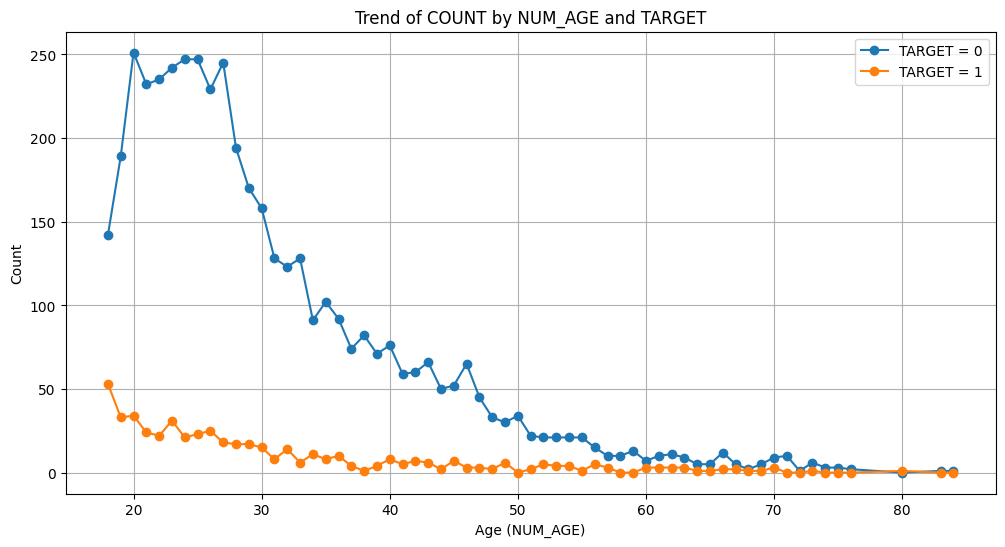

In [42]:
age_trends = grouped_age_target.groupby(['NUM_AGE', 'TARGET'])['COUNT'].sum().unstack(fill_value=0).reset_index()
# grouped_age_target_bank = df.groupby(['NUM_AGE', 'TEXT_BANK', 'TARGET']).size().reset_index(name='COUNT')
print(age_trends)

plt.figure(figsize=(12, 6))
plt.plot(age_trends['NUM_AGE'], age_trends[0], label='TARGET = 0', marker='o')
plt.plot(age_trends['NUM_AGE'], age_trends[1], label='TARGET = 1', marker='o')
plt.title('Trend of COUNT by NUM_AGE and TARGET')
plt.xlabel('Age (NUM_AGE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

TARGET  NUM_AGE    0   1  TARGET_RATE
0            18  142  53     0.271795
1            19  189  33     0.148649
2            20  251  34     0.119298
3            21  232  24     0.093750
4            22  235  22     0.085603
..          ...  ...  ..          ...
57           75    3   0     0.000000
58           76    2   0     0.000000
59           80    0   1     1.000000
60           83    1   0     0.000000
61           84    1   0     0.000000

[62 rows x 4 columns]


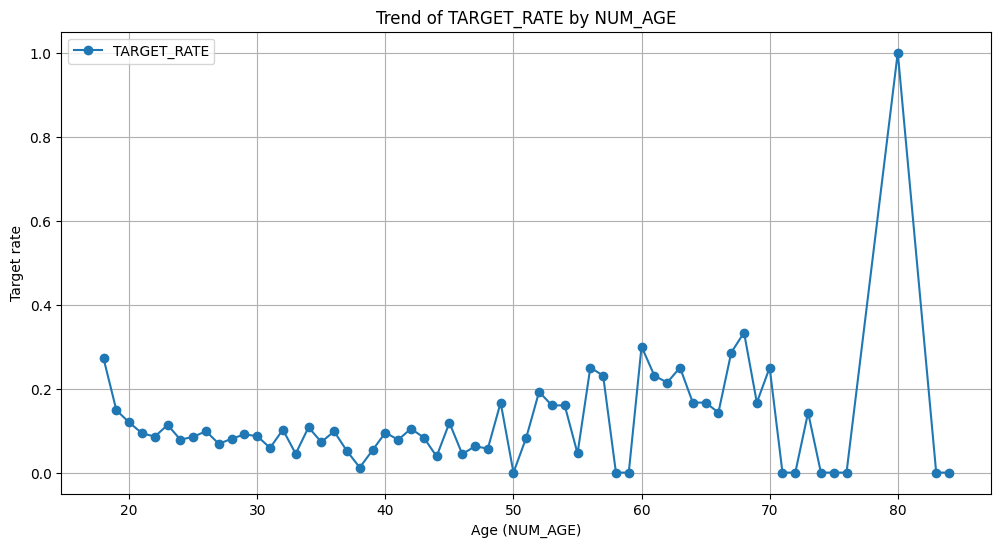

In [43]:
age_trends['TARGET_RATE'] = age_trends[1] / (age_trends[0] + age_trends[1])
print(age_trends)

plt.figure(figsize=(12, 6))
plt.plot(age_trends['NUM_AGE'], age_trends['TARGET_RATE'], label='TARGET_RATE', marker='o')
plt.title('Trend of TARGET_RATE by NUM_AGE')
plt.xlabel('Age (NUM_AGE)')
plt.ylabel('Target rate')
plt.legend()
plt.grid(True)
plt.show()

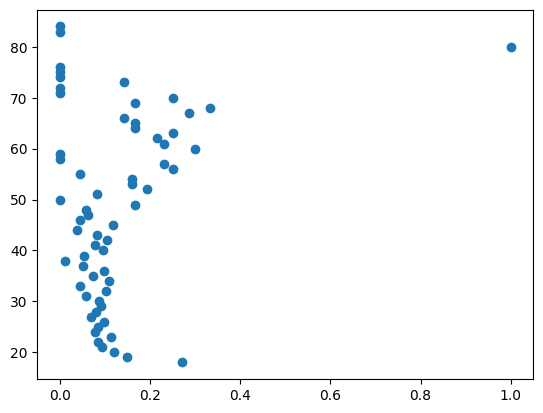

In [44]:
plt.scatter(age_trends['TARGET_RATE'], age_trends['NUM_AGE'])
plt.show()

In [45]:
def scatter_plot_by_age_group(age_trends):
    cluster_0 = age_trends[age_trends['Age_Group'] == 0]
    cluster_1 = age_trends[age_trends['Age_Group'] == 1]
    cluster_2 = age_trends[age_trends['Age_Group'] == 2]
    cluster_3 = age_trends[age_trends['Age_Group'] == 3]
    cluster_4 = age_trends[age_trends['Age_Group'] == 4]
    cluster_5 = age_trends[age_trends['Age_Group'] == 5]

    plt.scatter(cluster_0['TARGET_RATE'], cluster_0['NUM_AGE'], label='Cluster 0')
    plt.scatter(cluster_1['TARGET_RATE'], cluster_1['NUM_AGE'], label='Cluster 1')
    plt.scatter(cluster_2['TARGET_RATE'], cluster_2['NUM_AGE'], label='Cluster 2')
    plt.scatter(cluster_3['TARGET_RATE'], cluster_3['NUM_AGE'], label='Cluster 3')
    plt.scatter(cluster_4['TARGET_RATE'], cluster_4['NUM_AGE'], label='Cluster 4')
    plt.scatter(cluster_5['TARGET_RATE'], cluster_5['NUM_AGE'], label='Cluster 5')
    plt.show()

In [46]:
def age_clusters(age_stats):
    age_labels = []
    for i, bin in age_stats.iterrows():
        label = f'{bin['min']} - {bin['max']}'
        age_labels.append(label)

    age_bins = []
    age_bins.append(int(age_stats['min'][0]))
    age_bins.extend(age_stats['max'].to_list())
    return age_bins, age_labels

def target_rate_by_age_group(age_bins, age_labels):
    age_pivot = df
    age_pivot['age_range'] = pd.cut(age_pivot["NUM_AGE"], bins=age_bins, labels=age_labels, right=False)
    age_pivot = age_pivot.pivot_table(index='age_range', columns=['TARGET'], aggfunc='size', fill_value=0)
    age_pivot['TARGET_RATE'] = age_pivot[1] / (age_pivot[0] + age_pivot[1]) * 100
    return age_pivot

def target_rate_by_age_group_and_bank(age_bins, age_labels):
    # age_trends = age_trends[~age_trends['NUM_AGE'].isin(missing_ages)]

    grouped_age_target_bank_output = grouped_age_target_bank_output[grouped_age_target_bank_output['COUNT'] != 0]
    age_bank_pivot = df
    age_bank_pivot['age_range'] = pd.cut(age_bank_pivot["NUM_AGE"], bins=age_bins, labels=age_labels, right=False)
    age_pivot = age_pivot.pivot_table(index='age_range', columns=['TARGET'], aggfunc='size', fill_value=0)
    age_pivot['TARGET_RATE'] = age_pivot[1] / (age_pivot[0] + age_pivot[1]) * 100
    return age_pivot

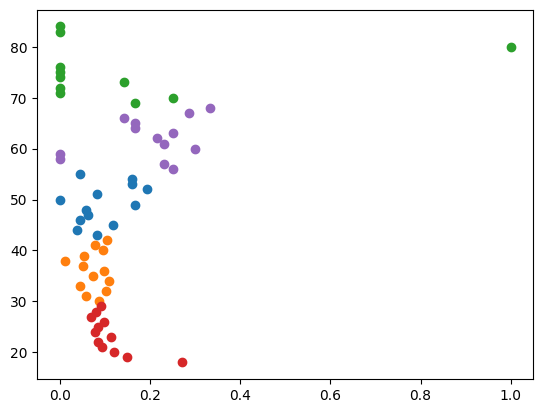

[18, 29, 42, 55, 68, 84]
['18 - 29', '30 - 42', '43 - 55', '56 - 68', '69 - 84']
TARGET        0    1  TARGET_RATE
age_range                        
18 - 29    2453  301    10.929557
30 - 42    1354  111     7.576792
43 - 55     520   51     8.931699
56 - 68     133   27    16.875000
69 - 84      42    7    14.285714


/tmp/ipykernel_6240/1840641847.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  age_pivot = age_pivot.pivot_table(index='age_range', columns=['TARGET'], aggfunc='size', fill_value=0)


In [47]:
age_trends['Age_Group'] = KMeans(n_clusters=5, random_state=0).fit_predict(age_trends[['NUM_AGE']])
age_stats = age_trends.groupby('Age_Group')['NUM_AGE'].agg(['min', 'max']).reset_index()
age_stats = age_stats.sort_values('min').reset_index()

scatter_plot_by_age_group(age_trends=age_trends)
age_bins, age_labels = age_clusters(age_stats)

age_table = target_rate_by_age_group(age_bins, age_labels)

print(age_bins)
print(age_labels)
print(age_table)

In [48]:
non_zero_banks = grouped_age_target_bank_output.groupby(['NUM_AGE', 'TEXT_BANK'])['COUNT'].transform('sum') > 0
filtered_data = grouped_age_target_bank_output[non_zero_banks]

target_rate_data = filtered_data.pivot_table(
    index=['NUM_AGE', 'TEXT_BANK'],
    columns='TARGET',
    values='COUNT',
    aggfunc='sum',
    fill_value=0
).reset_index()

target_rate_data.columns.name = None  # Remove the multi-index for clarity
target_rate_data = target_rate_data.rename(columns={0: 'COUNT_0', 1: 'COUNT_1'})

# target_rate_data['TARGET_RATE'] = target_rate_data['COUNT_1'] / (target_rate_data['COUNT_0'] + target_rate_data['COUNT_1']) * 100
# target_rate_data = target_rate_data.drop(columns=['COUNT_0', 'COUNT_1'])
print(target_rate_data)
target_rate_data.to_csv("target_rate_data.csv")

# grouped_age_target_bank_output['age_range'] = pd.cut(target_rate_data["NUM_AGE"], bins=age_bins, labels=age_labels, right=False)
# print(grouped_age_target_bank_output)

# age_pivot = grouped_age_target_bank_output.pivot_table(index='age_range', columns=['TARGET'], aggfunc='size', fill_value=0)
# age_pivot['TARGET_RATE'] = age_pivot[1] / (age_pivot[0] + age_pivot[1]) * 100

target_rate_data['AGE_CATEGORY'] = pd.cut(target_rate_data['NUM_AGE'], bins=age_bins, labels=age_labels, right=False)

# Group by TEXT_BANK and AGE_CATEGORY to calculate totals
result = target_rate_data.groupby(['TEXT_BANK', 'AGE_CATEGORY']).agg(
    TOTAL_COUNT_0=('COUNT_0', 'sum'),
    TOTAL_COUNT_1=('COUNT_1', 'sum')
).reset_index()

result['TARGET_RATE'] = result['TOTAL_COUNT_1'] / ( result['TOTAL_COUNT_1'] +  result['TOTAL_COUNT_0']) * 100
result = result.drop(columns=['TOTAL_COUNT_1', 'TOTAL_COUNT_0'])

print(result)
result.to_csv("result.csv")

     NUM_AGE                            TEXT_BANK  COUNT_0  COUNT_1
0         18                        Air Bank a.s.       20       11
1         18                       Equa bank a.s.        8        1
2         18                      Fio banka, a.s.        2        3
3         18                 Komerční banka, a.s.       14        2
4         18              MONETA Money Bank, a.s.       14        3
..       ...                                  ...      ...      ...
503       75               Česká spořitelna, a.s.        2        0
504       76               Česká spořitelna, a.s.        2        0
505       80               Česká spořitelna, a.s.        0        1
506       83  Československá obchodní banka, a.s.        1        0
507       84               Česká spořitelna, a.s.        1        0

[508 rows x 4 columns]
                 TEXT_BANK AGE_CATEGORY  TARGET_RATE
0            Air Bank a.s.      18 - 29    12.871287
1            Air Bank a.s.      30 - 42     6.763285
2

/tmp/ipykernel_6240/2853268814.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = target_rate_data.groupby(['TEXT_BANK', 'AGE_CATEGORY']).agg(


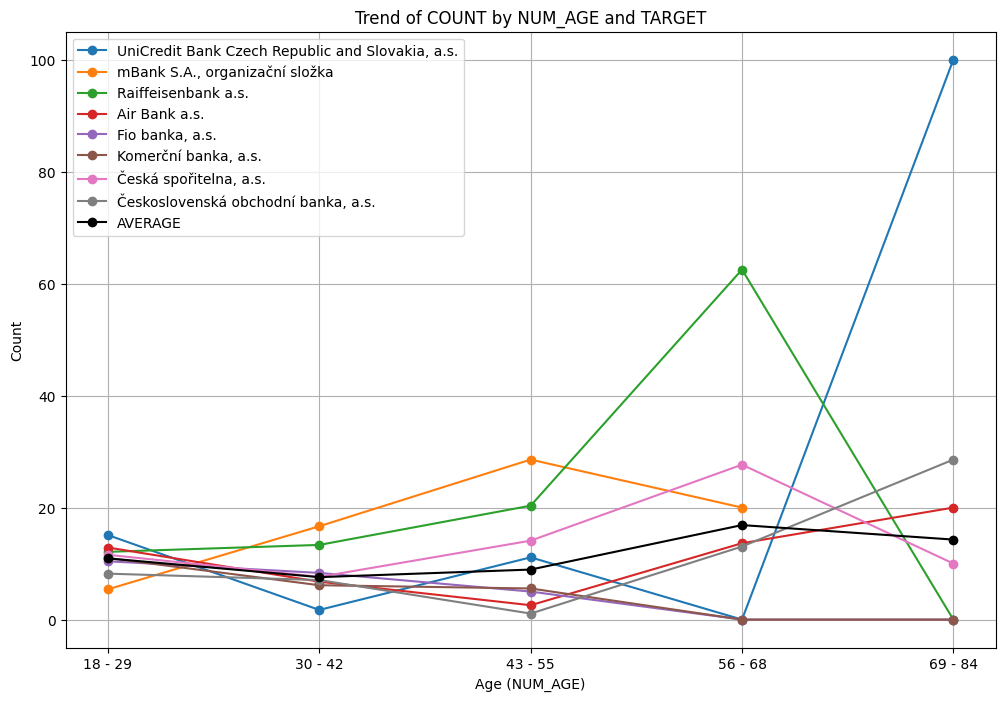

In [49]:
banks_of_interest = ["UniCredit Bank Czech Republic and Slovakia, a.s.",
                     "mBank S.A., organizační složka",
                     "Raiffeisenbank a.s.",
                     "Air Bank a.s.",
                     "Fio banka, a.s.",
                     "Komerční banka, a.s.",
                     "Česká spořitelna, a.s.",
                     "Československá obchodní banka, a.s."]

plt.figure(figsize=(12, 8))

for i in banks_of_interest:
    line_result = result[result['TEXT_BANK'] == i]
    plt.plot(line_result['AGE_CATEGORY'], line_result['TARGET_RATE'], label=str(i), marker='o')
plt.plot(line_result['AGE_CATEGORY'], age_table['TARGET_RATE'], label="AVERAGE", marker='o', color='black')
plt.title('Trend of COUNT by NUM_AGE and TARGET')
plt.xlabel('Age (NUM_AGE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# for a in age_labels:
#        fig, ax = plt.subplots()

#        y = []
#        for i in unique_banks:
#               line_result = result[result['AGE_CATEGORY'] == a]

#               line_result = line_result[line_result['TEXT_BANK'] == i]
#               y.append(float(line_result['TARGET_RATE']))

#        ax.bar(np.arange(len(unique_banks)), y, width=1, edgecolor="white", linewidth=0.7)

#        plt.show()

# for i, bank in enumerate(unique_banks):
#        print(f'{i}: {bank}')

TARGET                     1.000000
AMT_REQUESTED_TICKET       0.097672
NFLAG_EMAIL_NUMERAL        0.063183
NFLAG_MOBILEDEVICE         0.049548
CNT_REJECTED               0.021016
AMT_NET_INCOME            -0.005383
NUM_AGE                   -0.016993
CODE_ZIP                  -0.051094
CODE_IP_1                 -0.060223
NUM_LEVEN_EMAIL           -0.061472
NUM_DAYS_CREDIT_HISTORY   -0.084674
dtype: float64
TARGET                     1.000000
AMT_REQUESTED_TICKET       0.099741
NFLAG_EMAIL_NUMERAL        0.063183
NFLAG_MOBILEDEVICE         0.049548
CNT_REJECTED               0.019977
AMT_NET_INCOME            -0.011197
CODE_ZIP                  -0.048379
NUM_AGE                   -0.056914
NUM_LEVEN_EMAIL           -0.069207
CODE_IP_1                 -0.069220
NUM_DAYS_CREDIT_HISTORY   -0.155819
dtype: float64
      CODE_ZIP  AMT_NET_INCOME  AMT_REQUESTED_TICKET  \
0        18100           22000                8000.0   
1        79501           28000               10000.0   
2        6

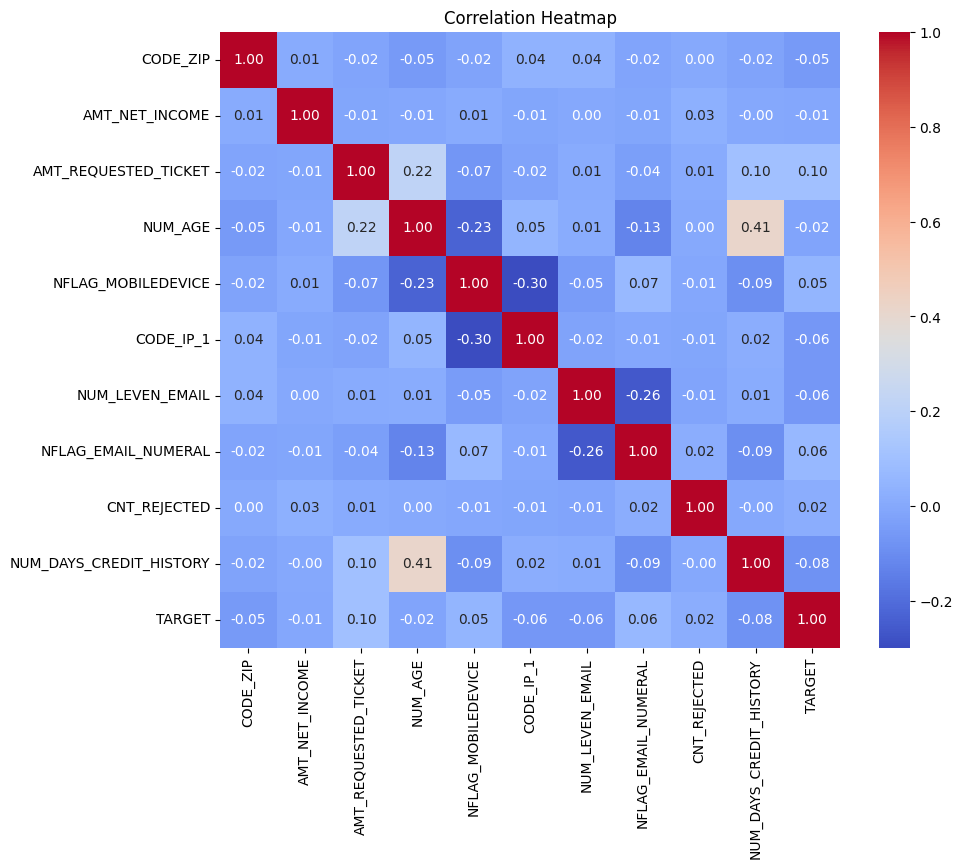

In [51]:
# Use the Pearson or Spearman correlation coefficient to measure linear or monotonic relationships, respectively.
correlations = df.corrwith(df['TARGET'], method='pearson', numeric_only=True)
print(correlations.sort_values(ascending=False))

correlations = df.corrwith(df['TARGET'], method='spearman', numeric_only=True)
print(correlations.sort_values(ascending=False))

print(df)
heatmap_prep = df.drop(columns=["TEXT_GENDER", "TEXT_BANK", "age_range"])
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_prep.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Select top 10 features
# X_new = SelectKBest(chi2, k=10).fit_transform(encoded_df, df['TARGET'])


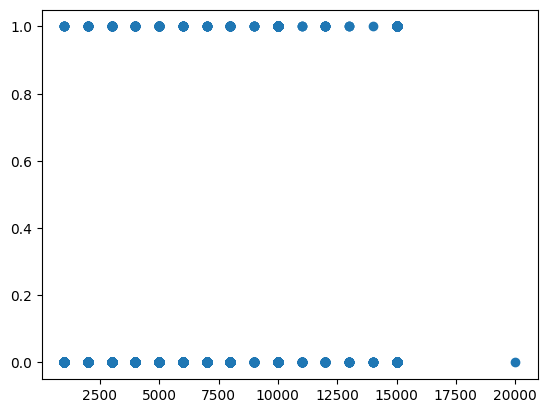

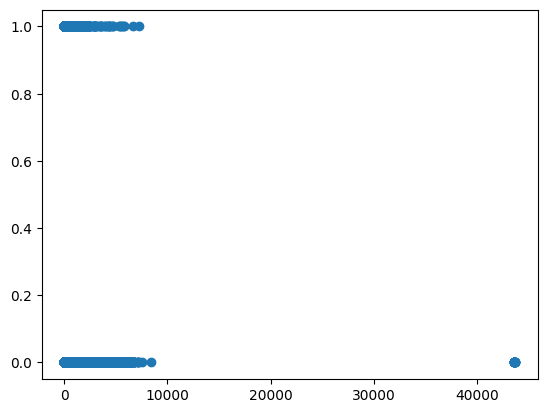

In [52]:
# replace cathegorical values with numberic ones

plt.scatter(df['AMT_REQUESTED_TICKET'], df['TARGET'])
plt.show()

plt.scatter(df['NUM_DAYS_CREDIT_HISTORY'], df['TARGET'])
plt.show()

In [96]:
model_df = df
model_df['GENDER'] = model_df['TEXT_GENDER'].map({'Muž': 0, 'Žena': 1})

# https://www.ceskaposta.cz/ke-stazeni/zakaznicke-vystupy

post_codes = pd.read_csv("pcs.csv", encoding='iso8859-2')
post_codes.rename(columns={'PSC': 'CODE_ZIP'}, inplace=True)

model_df = model_df.merge(post_codes[['CODE_ZIP', 'NAZOKRESU']], on='CODE_ZIP', how='left')
model_df = model_df.drop(columns=['Gender'])

print(model_df)
# model_df['CODE_ZIP']

KeyError: "['Gender'] not found in axis"

                    Feature  Importance
1      AMT_REQUESTED_TICKET    0.393555
11        age_range_56 - 68    0.222962
10        age_range_43 - 55    0.191664
6              CNT_REJECTED    0.118083
5       NFLAG_EMAIL_NUMERAL    0.093546
2        NFLAG_MOBILEDEVICE    0.041612
12        age_range_69 - 84    0.010362
8                    GENDER   -0.008904
9         age_range_30 - 42   -0.011278
0            AMT_NET_INCOME   -0.036198
3                 CODE_IP_1   -0.175852
4           NUM_LEVEN_EMAIL   -0.177982
7   NUM_DAYS_CREDIT_HISTORY   -1.219970


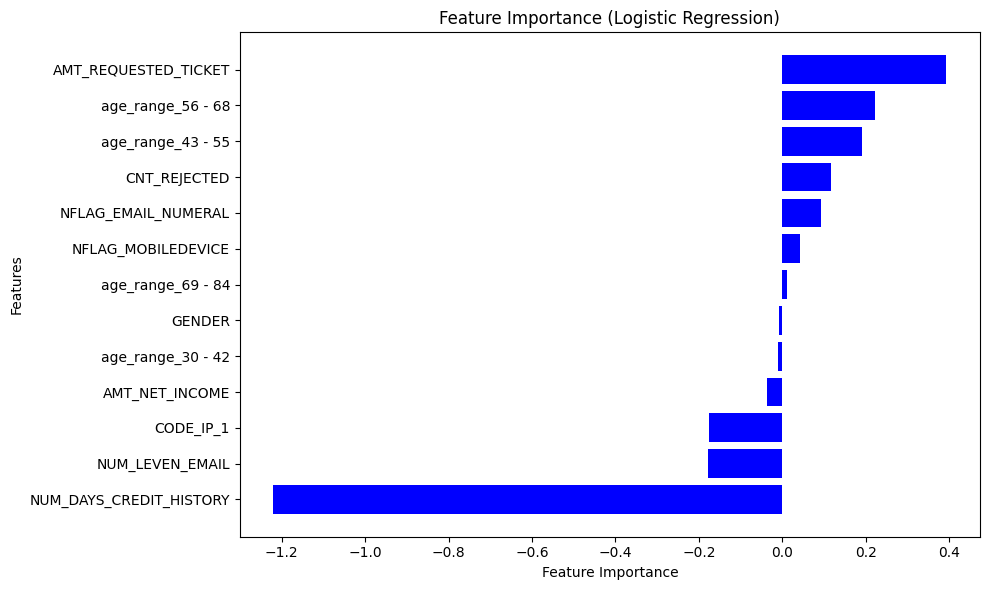

In [107]:
regression = model_df
X = regression.drop(columns=['TARGET', 'TEXT_BANK', 'NUM_AGE', 'CODE_ZIP', 'TEXT_GENDER', 'NAZOKRESU'])  # Drop target column
y = regression['TARGET']

# Handle categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Logistic Regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Get feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', ascending=False)

print(feature_importance)
feature_importance.to_csv("feature_importance.csv")
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.tight_layout()
plt.show()

In [76]:
pred_test = model.predict(X_test_scaled)
pred =  1 - model.predict_proba(X_test_scaled)[:,1]
print(pred)

[0.89072922 0.9036194  0.96981665 ... 0.95584787 0.9558344  0.90264615]


In [85]:
def count_unreliable_set(dataframe):
    total_target_rate = dataframe['TARGET'].sum() / len(dataframe)
    return total_target_rate

In [109]:
filtered_df = model_df
filtered_df = filtered_df.sort_values('CNT_REJECTED', ascending=False)
filtered_df = filtered_df[(filtered_df['age_range'] == '56 - 68') | (filtered_df['age_range'] == '43 - 55') ]
filtered_df = filtered_df.sort_values('AMT_REQUESTED_TICKET', ascending=False)
filtered_df = filtered_df.sort_values('NUM_DAYS_CREDIT_HISTORY', ascending=True)

filtered_df.to_csv("unreliable.csv")

res = count_unreliable_set(filtered_df.head(200))
print(res)

res = count_unreliable_set(df)
print(res)

11242
0.54
0.0994
